# Chapter 2 - working with text
In this chapter i will demonstrate dwonload of an hebrew text, and creating embeddings for that text.
I chose to work with the Torah text - it is interesting and quiet long.
I used stanza library to for tokenization (work better than alephbert, to my humble opinion).
Other than these changes I followed the book code, with some embeddings demonstrations at the end of this notebook.
## 1. download text (hebrew)


In [40]:
import requests
import re

books = ["Genesis", "Exodus", "Leviticus", "Numbers", "Deuteronomy"]

def clean_and_format(text):
    text = text.replace('־', ' ')
    
    text = re.sub(r'<[^>]+>', ' ', text)

    # # no hebrew punctuation
    text = re.sub(r'׃', r'.', text)
    text = re.sub(r'[\u0591-\u05C7]', '', text)
   
    text = re.sub(r'[;?!&]', '', text) 
    # remove english letters
    text = re.sub(r'[a-zA-Z]', '', text)
    # # remove curly braces with text in them
    text = re.sub(r'\{.*?\}', '', text)
    # text = re.sub(r'\n', '.\n', text)
    # text = " ".join(text.split())
    
    return text

def fetch_torah_text(filename="torah.txt"):
    print(f"Downloading and processing Torah text to {filename}...")
    
    with open(filename, "w", encoding="utf-8") as f:
        for book in books:
            print(f"Processing {book}...")
            url = f"https://www.sefaria.org/api/texts/{book}?context=0&pad=0"
            response = requests.get(url)
            
            if response.status_code == 200:
                data = response.json()
                text_content = data['he'] 
                
                for chapter in text_content:
                    for verse in chapter:
                        clean_verse = clean_and_format(verse)
                        
                        if clean_verse:
                            f.write(clean_verse + "\n")
            else:
                print(f"Error downloading {book}")

    print("Finished. ")


fetch_torah_text("torah.txt")

Processing Genesis...
Processing Exodus...
Processing Leviticus...
Processing Numbers...
Processing Deuteronomy...
Finished. 


### 2.Imports and backend configuration
Configuration for mac hardware

In [41]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
import stanza

# Check if MPS is supported and available- I'm using mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success: Using Apple M2 GPU Acceleration")
else:
    device = torch.device("cpu")
    print("Using CPU (Slow)")

Success: Using Apple M2 GPU Acceleration


### 3.Using stanza library for hebrew tokenization
I found it better than alephbert.
Tokenization proccess take a while but it is one time only.

In [42]:
import os

stanza.download("he")
try:
    nlp = stanza.Pipeline(
        lang="he", processors="tokenize,mwt", device=device  
    )
    print(f"Success! Running on: {nlp.device}")

except Exception as e:
    print(f"Failed to load on {device}, falling back to CPU. Error: {e}")
    nlp = stanza.Pipeline(lang="he", processors="tokenize,mwt", device="cpu")
with open("torah.txt", "r", encoding="utf-8") as f:
    torah_text = f.read()
doc = nlp(torah_text)
text = [word.text for sent in doc.sentences for word in sent.words]
print("Tokenization complete using Stanza tokenizer.")

# ensure output directory exists to avoid FileNotFoundError
os.makedirs("output", exist_ok=True)

with open("output/text_stanza.json", "w", encoding="utf-8") as f:
    json.dump(text, f, ensure_ascii=False)
    print("Text data saved to 'output/text_stanza.json'")

2026-01-27 23:27:41 INFO: Downloaded file to /Users/erannovak/stanza_resources/resources.json
2026-01-27 23:27:41 INFO: Downloading default packages for language: he (Hebrew) ...
2026-01-27 23:27:41 INFO: File exists: /Users/erannovak/stanza_resources/he/default.zip
2026-01-27 23:27:43 INFO: Finished downloading models and saved to /Users/erannovak/stanza_resources
2026-01-27 23:27:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2026-01-27 23:27:44 INFO: Downloaded file to /Users/erannovak/stanza_resources/resources.json
2026-01-27 23:27:44 INFO: Loading these models for language: he (Hebrew):
| Processor | Package           |
---------------------------------
| tokenize  | combined_nocharlm |
| mwt       | combined          |

2026-01-27 23:27:44 INFO: Using device: mps
2026-01-27 23:27:44 INFO: Loading: tokenize
2026-01-27 23:27:44 INFO:

Success! Running on: mps
Tokenization complete using Stanza tokenizer.
Text data saved to 'output/text_stanza.json'


### 4. Create vocabulary and prepare for emmbedings training

In [111]:
text = json.load(open("output/text_stanza.json", "r", encoding="utf-8"))
# print(text[:30])
print(f"text length: {len(text)}")
vocab = sorted(set(text))
print(f"Vocabulary size: {len(vocab)}")
word2idx = {token: idx for idx, token in enumerate(vocab)}
idx2word = {idx: token for token, idx in enumerate(vocab)}

text length: 120765
Vocabulary size: 9109


#### Generating skip-grams

In [102]:
def generate_skip_grams(text, window_size=4):
    skip_grams = []
    for i, word in enumerate(text):
        # Define the context window
        start = max(0, i - window_size)
        end = min(len(text), i + window_size + 1)
        context = [w for j, w in enumerate(text[start:end]) if j != window_size]
        for w in context:
            skip_grams.append((word, w))
    return skip_grams


skip_grams = generate_skip_grams(text)
print(f"Total skip-grams generated: {len(skip_grams)}")
with open("output/skip_grams.json", "w", encoding="utf-8") as f:
    json.dump(skip_grams, f)
    print("Skip-grams data saved to 'output/skip_grams.json'")

Total skip-grams generated: 966100
Skip-grams data saved to 'output/skip_grams.json'


#### Creating dataset

In [103]:
WINDOW_SIZE = 4

class Word2VecDataset(Dataset):
    def __init__(self, tokens, window_size=WINDOW_SIZE):
        self.data = []
        # Generate all positive pairs once
        for i, center_word in enumerate(tokens):
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    self.data.append((word2idx[center_word], word2idx[tokens[j]]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        center, context = self.data[idx]
        return torch.tensor(center), torch.tensor(context)

#### skip gram negative sampling

In [104]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegativeSampling, self).__init__()

        # We need two sets of embeddings:
        # 1. Target embeddings (center words)
        # 2. Context embeddings (words surrounding the center)
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)
        self.out_embed = nn.Embedding(vocab_size, embedding_dim)

        # Initialize weights for better convergence
        self.in_embed.weight.data.uniform_(-0.5, 0.5)
        self.out_embed.weight.data.uniform_(-0.5, 0.5)

    def forward(self, input_words, output_words):
        # input_words shape: [batch_size]
        # output_words shape: [batch_size] (positives) OR [batch_size * k] (negatives)

        in_vecs = self.in_embed(input_words)  # Shape: [batch_size, emb_dim]
        out_vecs = self.out_embed(output_words)  # Shape: [batch_size, emb_dim]

        # We want the dot product of input * output
        # For negatives, we might need to unsqueeze to match dimensions if K > 1
        # But here is the simplest batch implementation:

        # Element-wise multiplication then sum over embedding dimension
        scores = torch.sum(in_vecs * out_vecs, dim=1)

        # Note: No Sigmoid here because we use BCEWithLogitsLoss later
        return scores

### 5. Training embeddings 

In [105]:
VOCAB_SIZE = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 64
K_NEGATIVES = 32 # Number of negative samples per real pair
LR = 0.002  # found 0.002 as suitable learning rate
EPOCHS = 15

dataset = Word2VecDataset(text, window_size=WINDOW_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SkipGramNegativeSampling(VOCAB_SIZE, EMBEDDING_DIM)
model.to(device)
# BCEWithLogitsLoss combines Sigmoid + Binary Cross Entropy (Numerically stable)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"Training on vocab size {VOCAB_SIZE} with {len(dataset)} pairs...")

Training on vocab size 9109 with 966100 pairs...


#### Training loop
(takes approx 30 minutes on my mac)

In [106]:
for epoch in range(EPOCHS):
    total_loss = 0

    for center_batch, context_batch in dataloader:
        center_batch = center_batch.to(device)
        context_batch = context_batch.to(device)
        # --- A. Positive Samples (Real pairs) ---
        # Label is 1 for real pairs
        pos_scores = model(center_batch, context_batch)
        pos_labels = torch.ones_like(pos_scores, device=device)
        pos_loss = criterion(pos_scores, pos_labels)

        # --- B. Negative Samples (Fake pairs) ---
        # Generate random words from vocab (noise)
        # Shape: [Batch_Size * K]
        neg_context = torch.randint(
            0, VOCAB_SIZE, (len(center_batch) * K_NEGATIVES,), device=device
        )

        # Repeat center words to match negative context count
        # [center1, center2] -> [center1, center1, center1..., center2, center2...]
        center_batch_expanded = center_batch.repeat_interleave(K_NEGATIVES)

        # Label is 0 for fake pairs
        neg_scores = model(center_batch_expanded, neg_context)
        neg_labels = torch.zeros_like(neg_scores, device=device)
        neg_loss = criterion(neg_scores, neg_labels)

        # --- C. Update ---
        loss = pos_loss + neg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss {total_loss/len(dataloader):.4f}")

# Saving model
torch.save(model.state_dict(), "output/word2vec_model_stanza_short.pth")

Epoch 1: Loss 0.6967
Epoch 2: Loss 0.5252
Epoch 3: Loss 0.4569
Epoch 4: Loss 0.4241
Epoch 5: Loss 0.4086
Epoch 6: Loss 0.4001
Epoch 7: Loss 0.3952
Epoch 8: Loss 0.3926
Epoch 9: Loss 0.3909
Epoch 10: Loss 0.3897
Epoch 11: Loss 0.3890
Epoch 12: Loss 0.3888
Epoch 13: Loss 0.3889
Epoch 14: Loss 0.3884
Epoch 15: Loss 0.3891


### View embeddings

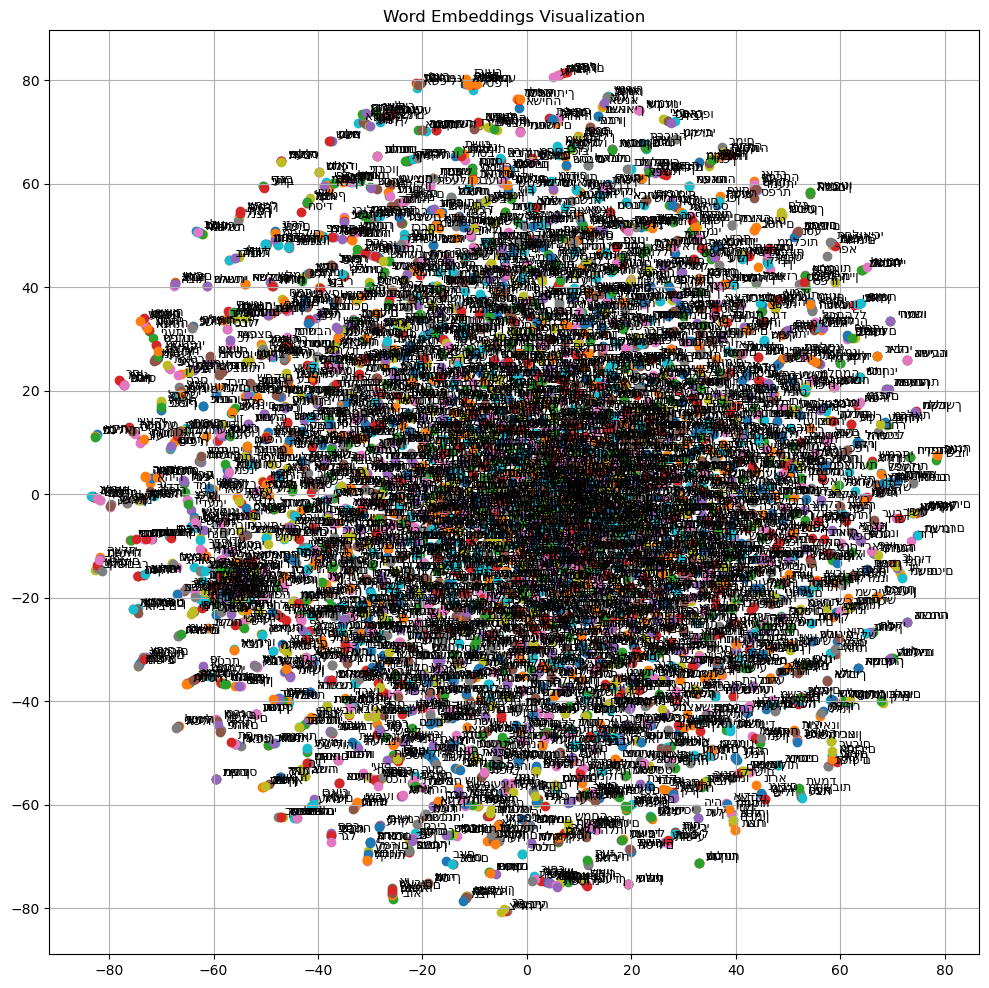

Word embeddings (first 5):
(: [ 0.4856864   0.21650414  0.21786353 -0.33218002  0.52688324]
): [ 0.9192732   0.10964394 -0.34356272  0.82702583  0.3508016 ]
.: [0.03361001 0.11158077 0.03213815 0.18083978 0.03778913]
[: [ 0.8376457  -0.4830801  -0.6915488   1.4413644   0.23177108]
]: [ 1.1429254  -0.28288484 -1.410251    1.2142454  -0.8682764 ]


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, word2idx):
    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 12))
    for word, idx in word2idx.items():
        plt.scatter(reduced[idx, 0], reduced[idx, 1])
        plt.annotate(word, fontsize=9, alpha=0.7)
    plt.title("Word Embeddings Visualization")
    plt.grid()
    plt.show()

    # Show the word embeddings
    print("Word embeddings (first 5):")
    for word, idx in list(word2idx.items())[:5]:
        print(f"{word}: {embeddings[idx][:5]}")
# Load model
model.load_state_dict(torch.load("output/word2vec_model_stanza.pth"))
model.to("cpu")  # Move to CPU for visualization

# Get the embeddings
with torch.no_grad():
    in_embeddings = model.in_embed.weight.cpu().numpy()
    out_embeddings = model.out_embed.weight.cpu().numpy()

# Visualize the embeddings
# ...existing code...
def visualize_embeddings(embeddings, word2idx):
    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 12))
    for word, idx in word2idx.items():
        x, y = reduced[idx]
        plt.scatter(x, y)
        plt.annotate(
            word,
            xy=(x, y),                 # required: the point to label
            xytext=(5, 2),             # offset the text a bit
            textcoords='offset points',
            fontsize=9
        )
    plt.title("Word Embeddings Visualization")
    plt.grid()
    plt.show()

    # Show the word embeddings
    print("Word embeddings (first 5):")
    for word, idx in list(word2idx.items())[:5]:
        print(f"{word}: {embeddings[idx][:5]}")
# ...existing code...
visualize_embeddings(in_embeddings, word2idx)

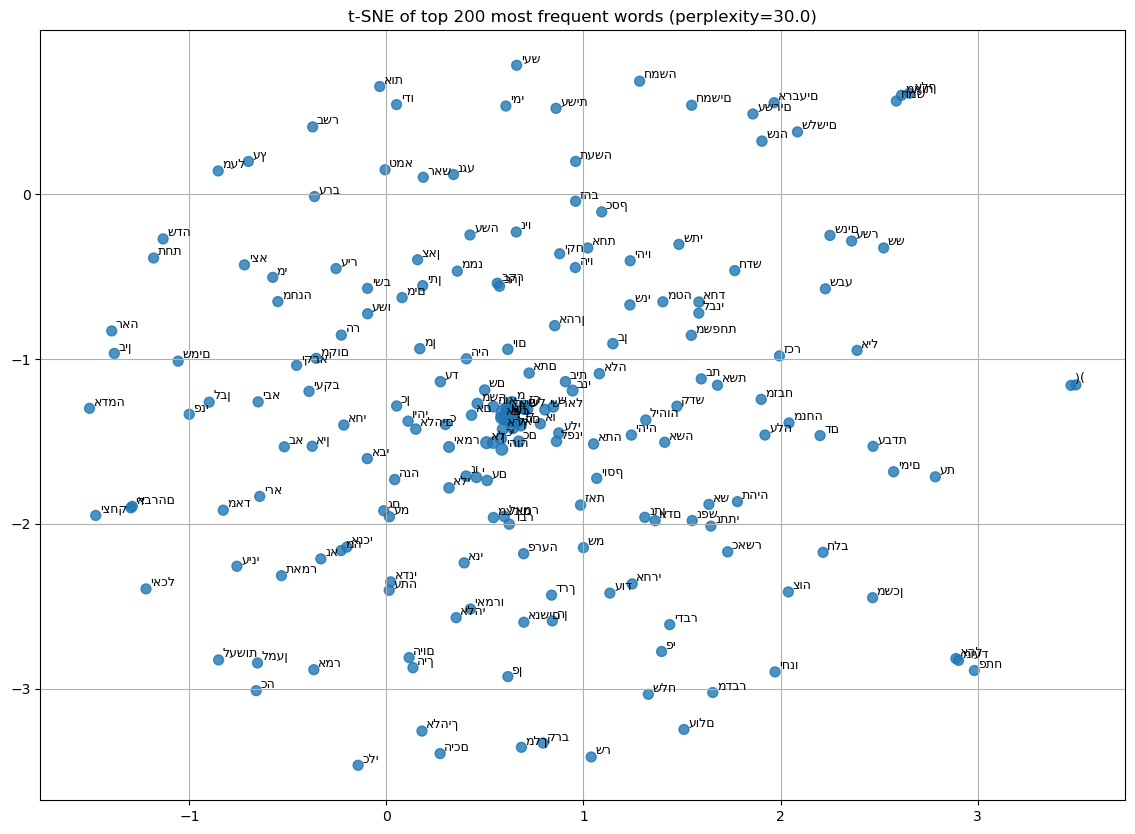

Top 20 frequent words: ['ו', 'ה', '.', 'את', 'ב', 'ל', 'אל', 'אשר', 'יהוה', 'כל', 'לא', 'על', 'כי', 'ך', 'ם', 'הם', 'בני', 'ארץ', 'כם', 'מ']


In [96]:

from collections import Counter

# Get 100 most frequent tokens from the tokenized text (variable `text`)
most_common = Counter(text).most_common(200)
words = [w for w, _ in most_common]
freqs = {w: f for w, f in most_common}

# Map to indices (skip missing tokens)
indices = [word2idx[w] for w in words if w in word2idx]
words = [w for w in words if w in word2idx]  # keep same order
if len(indices) < 2:
    raise ValueError("Not enough words found in vocabulary to visualize")

# Get embedding matrix (try known variables, fall back to model)
if 'in_embeddings' in globals():
    emb_matrix = in_embeddings
elif 'emb_tensor' in globals():
    emb_matrix = emb_tensor.cpu().numpy()
else:
    emb_matrix = model.in_embed.weight.detach().cpu().numpy()

viz_embs = np.array(emb_matrix)[indices]

# safe perplexity: must be < n_samples
n_samples = viz_embs.shape[0]
safe_perplexity = float(min(30, max(1, n_samples - 1)))

tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=safe_perplexity)
reduced = tsne.fit_transform(viz_embs)

plt.figure(figsize=(14, 10))
sizes = [50 + 200 * (freqs[w] / freqs[words[0]]) for w in words]  # relative sizes
plt.scatter(reduced[:, 0], reduced[:, 1], s=sizes, alpha=0.8)

for i, w in enumerate(words):
    plt.annotate(w, (reduced[i, 0], reduced[i, 1]), xytext=(3, 2), textcoords='offset points', fontsize=9)

plt.title(f"t-SNE of top {len(words)} most frequent words (perplexity={safe_perplexity})")
plt.grid(True)
plt.show()

# Print top 20 frequent words
print("Top 20 frequent words:", [w for w, _ in Counter(text).most_common(20)])
#

In [107]:
emb_tensor = None
state = torch.load("output/word2vec_model_stanza_short.pth", map_location=device)
if isinstance(state, dict):
    for key in (
        "in_embed.weight",
        "in_embed.weight",
        "out_embed.weight",
        "embeddings.weight",
        "embedding.weight",
        "encoder.weight",
    ):
        if (
            key in state
            and isinstance(state[key], torch.Tensor)
            and state[key].dim() == 2
        ):
            if state[key].size(0) == VOCAB_SIZE:
                emb_tensor = state[key]
                break

    if emb_tensor is None:
        for k, v in state.items():
            if (
                isinstance(v, torch.Tensor)
                and v.dim() == 2
                and v.size(0) == vocab_size
            ):
                emb_tensor = v
                break

if emb_tensor is None:
    raise RuntimeError(
        "Couldn't find a 2D embedding tensor matching VOCAB_SIZE in the saved state_dict."
    )
emb_tensor = emb_tensor.to(device)
print(f"Loaded embedding tensor of shape: {emb_tensor.shape}")

Loaded embedding tensor of shape: torch.Size([9109, 100])


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/var/folders/vb/0cfv67fd481b5zf98tps8h3h0000gn/T/ipykernel_20103/564138957.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  emb = np.array(embeddings.cpu())
/var/folders/vb/0cfv67fd481b5zf98tps8h3h0000gn/T/ipykernel_20103/564138957.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  emb = np.array(embeddings.cpu())


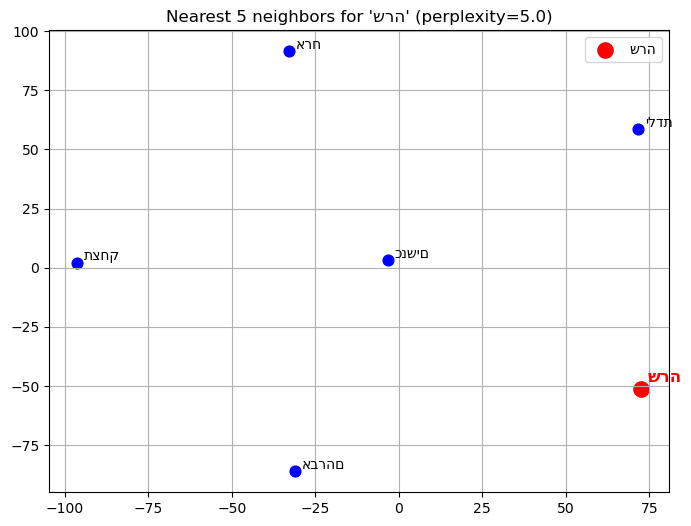

Nearest neighbors:
אברהם (idx=61)  sim=0.5345
תצחק (idx=8869)  sim=0.5171
כנשים (idx=4212)  sim=0.5012
ארח (idx=590)  sim=0.4681
ילדת (idx=3297)  sim=0.4669


ValueError: perplexity (30.0) must be less than n_samples (6)

In [122]:
def plot_word_with_neighbors(target_word, embeddings=emb_tensor, k=5):
    """
    Plot a target word and its k nearest neighbors based on cosine similarity.
    Uses global `word2idx` (token->idx). Rebuilds idx2word to be safe.
    """
    # rebuild correct idx->word mapping (fixes earlier notebook bug if present)
    idx2word = {idx: w for w, idx in word2idx.items()}

    if target_word not in word2idx:
        print(f"Word '{target_word}' not in vocabulary.")
        return

    # Ensure embeddings is numpy array
    emb = np.array(embeddings.cpu())
    vocab_size = emb.shape[0]

    # Normalize embeddings for cosine similarity
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1e-8
    emb_norm = emb / norms

    target_idx = word2idx[target_word]
    target_vec = emb_norm[target_idx]

    sims = emb_norm.dot(target_vec)  # cosine similarities
    top_idxs = np.argsort(sims)[::-1]
    neighbors = [i for i in top_idxs if i != target_idx][:k]

    viz_idxs = [target_idx] + neighbors
    viz_embs = emb[viz_idxs]
        # rebuild correct idx->word mapping (fixes earlier notebook bug if present)
    idx2word = {idx: w for w, idx in word2idx.items()}

    if target_word not in word2idx:
        print(f"Word '{target_word}' not in vocabulary.")
        return

    # Ensure embeddings is numpy array
    emb = np.array(embeddings.cpu())
    vocab_size = emb.shape[0]

    # Normalize embeddings for cosine similarity
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1e-8
    emb_norm = emb / norms

    target_idx = word2idx[target_word]
    target_vec = emb_norm[target_idx]

    sims = emb_norm.dot(target_vec)  # cosine similarities
    top_idxs = np.argsort(sims)[::-1]
    neighbors = [i for i in top_idxs if i != target_idx][:k]

    viz_idxs = [target_idx] + neighbors
    viz_embs = emb[viz_idxs]

    # Choose a safe perplexity: must be < n_samples
    n_samples = viz_embs.shape[0]
    safe_perplexity = float(min(30, max(1, n_samples - 1)))

    tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=safe_perplexity)
    reduced = tsne.fit_transform(viz_embs)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[0, 0], reduced[0, 1], c='red', s=120, label=target_word)
    plt.annotate(target_word, (reduced[0, 0], reduced[0, 1]), xytext=(5, 5), textcoords='offset points',
                    fontsize=12, fontweight='bold', color='red')

    for i, idx in enumerate(neighbors, start=1):
        w = idx2word[idx]
        plt.scatter(reduced[i, 0], reduced[i, 1], c='blue', s=60)
        plt.annotate(w, (reduced[i, 0], reduced[i, 1]), xytext=(5, 2), textcoords='offset points', fontsize=10)

    plt.title(f"Nearest {k} neighbors for '{target_word}' (perplexity={safe_perplexity})")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    print("Nearest neighbors:")
    for idx in neighbors:
        print(f"{idx2word[idx]} (idx={idx})  sim={sims[idx]:.4f}")
    # ...existing code...)
    vocab_size = emb.shape[0]

    # Normalize embeddings for cosine similarity
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1e-8
    emb_norm = emb / norms

    target_idx = word2idx[target_word]
    target_vec = emb_norm[target_idx]

    sims = emb_norm.dot(target_vec)  # cosine similarities
    # get top k+1 indices (includes the word itself)
    top_idxs = np.argsort(sims)[::-1]
    # exclude the word itself and take top k neighbors
    neighbors = [i for i in top_idxs if i != target_idx][:k]

    # Prepare embeddings for visualization: target first, then neighbors
    viz_idxs = [target_idx] + neighbors
    viz_embs = emb[viz_idxs]

    # Use t-SNE to reduce to 2D
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reduced = tsne.fit_transform(viz_embs)

    plt.figure(figsize=(8, 6))
    # target point
    plt.scatter(reduced[0, 0], reduced[0, 1], c='red', s=120, label=target_word)
    plt.annotate(target_word, (reduced[0, 0], reduced[0, 1]), xytext=(5, 5), textcoords='offset points',
                 fontsize=12, fontweight='bold', color='red')

    # neighbor points
    for i, idx in enumerate(neighbors, start=1):
        w = idx2word[idx]
        plt.scatter(reduced[i, 0], reduced[i, 1], c='blue', s=60)
        plt.annotate(w, (reduced[i, 0], reduced[i, 1]), xytext=(5, 2), textcoords='offset points', fontsize=10)

    plt.title(f"Nearest {k} neighbors for '{target_word}'")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Print neighbors with similarity scores
    print(f"Nearest neighbors for:", target_word)
    for idx in neighbors:
        print(f"{idx2word[idx]} (idx={idx})  sim={sims[idx]:.4f}")

# Example usage:
plot_word_with_neighbors("שרה", k=5)